# ResNet Preprocessing

Copy this notebook and set the paths to start preprocessing your data.

Note: If you are going to update this notebooks, clear the outputs before committing.

## Loading the Data

The code below loads data and labels from GCS.

You should update the paths to save the data to the right place on
your local disk.

In [1]:
import os
import pathlib
import typing

import numpy as np

In [2]:
def load_data(data_dir: str) -> typing.Dict[str, np.ndarray]:
    """Returns a dictionary which maps patient ids
    to patient pixel data."""
    data_dict = {}
    for filename in os.listdir(data_dir):
        patient_id = filename[:-4] # remove .npy extension
        data_dict[patient_id] = np.load(pathlib.Path(data_dir) / filename)
    return data_dict

In [410]:
# data_dict = load_data('/home/elvo-analysis/data/numpy/')
lmao = load_data('/home/elvo-analysis/data/vessel_0')

### Labels

In [4]:
!gsutil cp gs://elvos/labels.csv /home/elvo-analysis/data/labels.csv

Copying gs://elvos/labels.csv...
/ [1 files][ 20.0 KiB/ 20.0 KiB]                                                
Operation completed over 1 objects/20.0 KiB.                                     


In [5]:
import pandas as pd

In [6]:
labels_df = pd.read_csv('/home/elvo-analysis/data/labels.csv',
                        index_col='patient_id')

## Preprocessing: Part I

If we use gs://elvos/numpy or gs://elvos/labels.csv, we'll have to do some minor
preprocessing first (removing bad data and duplicate labels).

In [7]:
def process_images(data: typing.Dict[str, np.ndarray]):
    return {id_: arr for id_, arr in data.items() if len(arr) != 1} # Remove the bad image

In [8]:
data_dict = process_images(data_dict)

In [9]:
def process_labels(labels: pd.DataFrame, data: typing.Dict[str, np.ndarray]):
    # TODO: Remove duplicate HLXOSVDF27JWNCMJ, IYDXJTFVWJEX36DO from ELVO_key
    labels = labels.loc[~labels.index.duplicated()] # Remove duplicate ids
    labels = labels.loc[list(data.keys())]
    assert len(labels) == len(data)
    return labels

In [10]:
labels_df = process_labels(labels_df, data_dict)

/home/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


## Data Exploration

Simple plotting of the (mostly) unprocessed data.

For the data in `numpy/`:
- The 6 smallest image heights are: 1, 160, 160, 162, 164, 181.
- The 5 smallest image lengths/widths are: 180, 191, 193, 195, 197.

In [11]:
%matplotlib inline

In [12]:
from matplotlib import pyplot as plt

In [354]:
def plot_images(data: typing.Dict[str, np.ndarray],
                labels: pd.DataFrame,
                num_cols: int,
                limit=20,
                offset=0):
    # Ceiling function of len(data) / num_cols
    num_rows = (min(len(data), limit) + num_cols - 1) // num_cols 
    fig = plt.figure(figsize=(10, 10))
    for i, patient_id in enumerate(data):
        if i < offset:
            continue
        if i >= offset + limit:
            break
        plot_num = i - offset + 1
        ax = fig.add_subplot(num_rows, num_cols, plot_num)
        ax.set_title(f'patient: {patient_id[:4]}...')
        label = 'positive' if labels.loc[patient_id]["label"] else 'negative'
        ax.set_xlabel(f'label: {label}')
        plt.imshow(data[patient_id])
    fig.tight_layout()
    plt.plot()

In [296]:
# Change the input to .transpose to see different views of the data
mipped_all = {k:data_dict[k].transpose(0, 2, 1).max(axis=2) for i, k in enumerate(data_dict)}

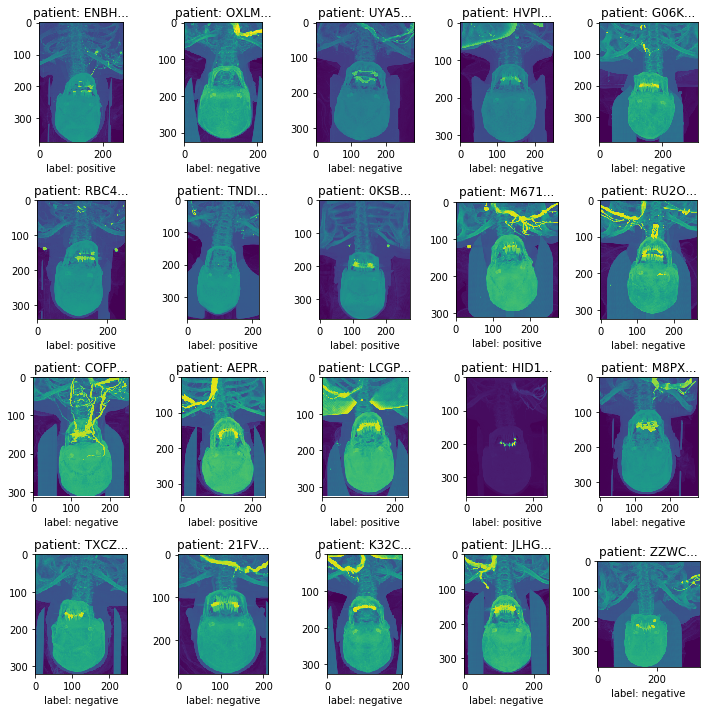

In [297]:
plot_images({k: arr for k, arr in mipped_all.items()}, labels_df, 5, offset=20)

## Preprocessing: Part II

Cropping the image, applying mip, etc.

You should

In [16]:
import scipy.ndimage

In [425]:
from skimage import measure, segmentation
from skimage.segmentation import clear_border
import cv2
from skimage.morphology import dilation, rectangle, erosion, opening, closing, convex_hull_image, disk, remove_small_holes

def segment(image):
    # Create binary image
    binary_image = np.array(image)
    binary_image = (binary_image > 120)

    # Split image by region, and get just the skull region. Dilate it to close small gaps.
    # Set skull to 0, everything else as -1.
    tmp = binary_image
    tmp = dilation(tmp)
    tmp = measure.label(tmp)
    area = [r.area for r in measure.regionprops(tmp)]
    tmp[tmp != np.argmax(area) + 1] = -1
    tmp[tmp == np.argmax(area) + 1] = 0
    
    # Pad around the area by 20, because we don't want the head to touch the image border
    tmp = np.pad(tmp, [(20, 20), (20, 20)], mode='constant', constant_values=-1)
    tmp = closing(tmp, disk(5))
    
    # If the skull is not a closed shape (e.g. in the sinus area, or if the head is cut off),
    # then it is not possible to distinguish the 'inside of the skull' from the 'outside'.
    # To fix this issue, we take the contour of a skull, and superimpose an approximated
    # ellipse shape given the skull.
    if len(np.unique(clear_border(tmp, bgval=0))) == 1:
        img_res = np.uint8(tmp) + 1
        edges = cv2.Canny(np.uint8(tmp), 50, 200)
        _, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contours = list(contours)
        contours.sort(key=lambda x : len(x))
        ellipse = cv2.fitEllipse(contours[-1])
        img_res = cv2.ellipse(img_res, ellipse, 1, thickness=2)
        tmp = np.int64(img_res) - 1

    # Set everything outside the skull to be of the same value as the skull.
    # Now there are two values (one representing the inside of the skull, one outside).
    # Set inside of skull to 1, outside to 0.
    tmp_border = clear_border(tmp, bgval=0)
    tmp_border[tmp_border == -1] = 1

    # Split image by region again. The largest region should now be the brain mass.
    # Set everything that is not the brain mass to 0.
    tmp_border = measure.label(tmp_border)
    area = [r.area for r in measure.regionprops(tmp_border)]
    tmp_border[tmp_border != np.argmax(area) + 1] = 0
    tmp_border[tmp_border == np.argmax(area) + 1] = 1

    # Dilate the brain mass region such that we don't exclude blood vessels near the skull.
    # Remove any small holes within the brain mass.
    tmp_border = dilation(tmp_border, disk(2))
    tmp_border = closing(tmp_border)
    tmp_border = remove_small_holes(tmp_border)

    # Remove the 20px padding. Now superimpose this mask on the original image.
    mask_index = (tmp_border[20:-20,20:-20] == 0)
    result = np.array(image)
    result[mask_index] = -50
    return result

def crop_z(image3d: np.ndarray,
         output_shape) -> np.ndarray:
    """Crops a 3d image in ijk form (height as axis 0).
    """
    assert image3d.shape[1] == image3d.shape[2]
    assert output_shape[1] == output_shape[2] # For now
    assert output_shape[1] <= image3d.shape[1]
    
    lw_center = image3d.shape[1] // 2
    lw_min = lw_center - output_shape[1] // 2
    lw_max = lw_center + output_shape[1] // 2
    for i in range(len(image3d) - 1, 0, -1):
        if image3d[i, lw_center, lw_center] >= 0:
            height_max = i - 30
            break
    height_min = height_max - output_shape[0]
    
    # cropped = image3d[height_min:height_max, lw_min:lw_max, lw_min:lw_max]
    cropped = image3d[height_min:height_max, :, :]
    # assert cropped.shape == output_shape
    return cropped

def crop_xy(image3d: np.ndarray,
         output_shape) -> np.ndarray:
    """Crops a 3d image in ijk form (height as axis 0).
    """
    assert image3d.shape[1] == image3d.shape[2]
    assert output_shape[1] == output_shape[2] # For now
    assert output_shape[1] <= image3d.shape[1]
    
    lw_center = image3d.shape[1] // 2
    lw_min = lw_center - output_shape[1] // 2
    lw_max = lw_center + output_shape[1] // 2
    
    cropped = image3d[:, lw_min:lw_max, lw_min:lw_max]
    # assert cropped.shape == output_shape
    return cropped


def bound_pixels(image3d: np.ndarray,
                 min_bound: float,
                 max_bound: float) -> np.ndarray:
    return np.clip(image3d, min_bound, max_bound)


def mip(image3d: np.ndarray) -> np.ndarray:
    """Make sure that the array has been transposed first!
    """
#     assert image3d.shape[0] == image3d.shape[1]
    return image3d.max(axis=0)


def downsample(image3d: np.ndarray, factor) -> np.ndarray:
    return scipy.ndimage.zoom(image3d, factor)
    

def to_grayscale(image2d: np.ndarray):
    return np.stack([image2d, image2d, image2d], axis=2)


def original_process_data(data: typing.Dict[str, np.ndarray]) -> typing.Dict[str, np.ndarray]:
    processed = {}
    for id_, arr in data.items():
        try:
            print(id_)
            arr = crop_z(arr, (75, 200, 200))
            arr = crop_xy(arr, (75, 200, 200))
            arr = np.stack([arr[0:25], arr[25:50], arr[50:75]])
#             arr = arr.max(axis=1)
            arr = bound_pixels(arr, 120, 500)
            arr[arr == 120] = -50
            arr[arr == 500] = -50
            arr = arr.max(axis=1)
            arr = np.moveaxis(arr, 0, -1)
            print(np.shape(arr))
            processed[id_] = arr
        except AssertionError:
            print(f'image for patient {id_} too small, has shape {arr.shape}')
    return processed

def process_data_1(data: typing.Dict[str, np.ndarray]) -> typing.Dict[str, np.ndarray]:
    processed = {}
    i = 0
    for id_, arr in data.items():
        print('{}/{}'.format(i, len(data)))
        i += 1
        layer = 0
        try:
            print(id_)
            arr = crop_z(arr, (75, 200, 200))
            print(np.shape(arr))
            processed[id_] = arr
        except AssertionError:
            print(f'image for patient {id_} too small, has shape {arr.shape}')
        except (AttributeError, ValueError) as e:
            print('Couldnt segment {} at layer {}'.format(id_, j))
    return processed


def process_data_2(data: typing.Dict[str, np.ndarray]) -> typing.Dict[str, np.ndarray]:
    processed = {}
    i = 0
    for id_, arr in data.items():
        print('{}/{}'.format(i, len(data)))
        i += 1
        layer = 0
        try:
            print(id_)
            arr = crop_z(arr, (75, 200, 200))
            tmp = []
            for j in range(75):
                layer = j
                tmp.append(segment(arr[j,:,:]))
            arr = np.array(tmp)
            print(np.shape(arr))
            processed[id_] = arr
        except AssertionError:
            print(f'image for patient {id_} too small, has shape {arr.shape}')
        except (AttributeError, ValueError) as e:
            print('Couldnt segment {} at layer {}'.format(id_, j))
    return processed

def process_data_3(data: typing.Dict[str, np.ndarray]) -> typing.Dict[str, np.ndarray]:
    processed = {}
    for id_, arr in data.items():
        try:
            print(id_)
            arr = crop_xy(arr, (75, 200, 200))
            arr = np.array([arr[0:25,:,:], arr[25:50,:,:], arr[50:75,:,:]])
            arr = np.moveaxis(arr, 0, -1)
            arr = mip(arr)
            arr = bound_pixels(arr, 120, 500)
            arr[arr == 120] = -50
            arr[arr == 500] = -50
#             arr = mip(arr)
            print(np.shape(arr))
            assert arr.shape == (200, 200, 3)
            processed[id_] = arr
        except AssertionError:
            print(f'image for patient {id_} too small, has shape {arr.shape}')
    return processed



In [426]:
# processed_dict = original_process_data(data_dict)
# processed_dict_1 = process_data_1(data_dict)
processed_dict_2_2 = process_data_2(data_dict)
# processed_dict_3 = process_data_3(processed_dict_2_1)

0/1076
RLF1AFE0G1Q98BS9


/home/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:194: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)
/home/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


(75, 250, 250)
1/1076
SUENUHMZ5JN7IWJE
(75, 357, 357)
2/1076
HIAEQWMTUGATOAVI
(75, 281, 281)
3/1076
7Y3X9QW1S5099X0O
(75, 232, 232)
4/1076
OLCBKEY2WKCWPHJW
(75, 250, 250)
5/1076
VFHSASVT4EXZWAOS
(75, 280, 280)
6/1076
TUI0SHMO3IO4PT8Z
(75, 280, 280)
7/1076
FVG8FNQ876DW8W9O
(75, 282, 282)
8/1076
QBOBDYYD4R7WP37S
(75, 305, 305)
9/1076
BHCMG7A3E5Y13T0J
(75, 280, 280)
10/1076
EG36PUNTKBPUZ4PG
(75, 248, 248)
11/1076
KACA7XHWXRM6A3W3
(75, 259, 259)
12/1076
KZMPFXLAUCRM314K
(75, 250, 250)
13/1076
JNTL5ESEIA5FWMUQ
(75, 250, 250)
14/1076
DZTDN47H2IKSYN3Q
(75, 235, 235)
15/1076
3ZBJ0AG0IB9BZ6G5
(75, 200, 200)
16/1076
T0ON17XI9DTJD8KO
(75, 280, 280)
17/1076
RRZNNMZTLY4BJK7C
(75, 289, 289)
18/1076
STCSWQHX4UN23CDK
(75, 217, 217)
19/1076
E7VL4CNODMURQN72
(75, 219, 219)
20/1076
ENBHS75LQ7FWO5CP
(75, 263, 263)
21/1076
OXLMK9HYYWBECM3T
(75, 213, 213)
22/1076
UYA5YJUAVC3SE6HV
(75, 280, 280)
23/1076
HVPI7QQSXPDHSFME
(75, 250, 250)
24/1076
G06KIRHKXWJZV4JL
(75, 313, 313)
25/1076
RBC423N4RNB3UZ5P
(75, 250,

(75, 235, 235)
204/1076
FCPTNB8PMLSG93N
(75, 229, 229)
205/1076
HAKJSG5CHDGOBP6B
(75, 280, 280)
206/1076
0E1AN2T001WORM02
(75, 280, 280)
207/1076
KK0ZHCZR9V87OESW
image for patient KK0ZHCZR9V87OESW too small, has shape (297, 197, 197)
208/1076
PB7YJZRJU74HFKTS
(75, 324, 324)
209/1076
CJNLJB43ZD3GIUN3
(75, 250, 250)
210/1076
ICWMS7OCXZLUTUFT
(75, 280, 280)
211/1076
8C0V0CZ2BRLSAMUM
(75, 235, 235)
212/1076
DNO6CS3YNGFMUWXL
(75, 250, 250)
213/1076
Q2ZSL21Z90QTPXY5
(75, 282, 282)
214/1076
2BXCJOQVAYCN0WFD
(75, 252, 252)
215/1076
ZSOO1JLX7GWD1AXI
(75, 217, 217)
216/1076
HO0Y1BBUIJE9IJIJ
(75, 280, 280)
217/1076
ANLMZN6NS4S3TCCF
(75, 250, 250)
218/1076
PNPGGIFOXWJJQ22P
(75, 250, 250)
219/1076
HZLBHRHYLSY9TXJ4
(75, 258, 258)
220/1076
ADVBNYHQ77F3AIMR
(75, 235, 235)
221/1076
QIA74LHB1XWMP523
(75, 289, 289)
222/1076
SUOSQFF89IZTMJTG
(75, 264, 264)
223/1076
Q9K5IEJR20DGZMSZ
(75, 262, 262)
224/1076
YLLD4EJGLL59WBG6
(75, 219, 219)
225/1076
XO2Z2XFH26YISRUA
(75, 280, 280)
226/1076
RSKIY1U4X5QAUAAK
(

(75, 250, 250)
397/1076
NHXCOHZ4HH53NLQ6
(75, 213, 213)
398/1076
W098UN5Y50II02BX
(75, 233, 233)
399/1076
AZKCIPFZYXES2I5R
(75, 280, 280)
400/1076
PKDK1R3JGEDSY9T2
(75, 281, 281)
401/1076
VOIUV38X58F3KY75
(75, 214, 214)
402/1076
JQWIIAADGKE2YMJS
(75, 235, 235)
403/1076
ZCMTUATV42LAXACO
(75, 293, 293)
404/1076
9WDSZR9939UAVNUL
(75, 390, 390)
405/1076
8LL3IE6PJ9GC2JX0
(75, 280, 280)
406/1076
CMELUGEVB3ESBIAK
(75, 245, 245)
407/1076
JOJU5LPDDBBP6LYG
(75, 280, 280)
408/1076
U5ZUK9GYCAM4FYK4
(75, 342, 342)
409/1076
EGIAP2GDM33PCW5A
(75, 235, 235)
410/1076
4DIUJ5A6193W879P
(75, 227, 227)
411/1076
Q8BNE59JIKQLLYJ1
(75, 257, 257)
412/1076
NELY4JKZT4KXHG1T
(75, 304, 304)
413/1076
MBRJCXKG522HOWH7
(75, 250, 250)
414/1076
JD6C377DW9DEXDDY
(75, 200, 200)
415/1076
9Z9TDQNM92R1FK71
(75, 250, 250)
416/1076
ABPO2BORDNF3OVL3
(75, 225, 225)
417/1076
HAD27IUS6FJC8BCO
(75, 250, 250)
418/1076
MW8YUZAR8U4OOCH4
(75, 225, 225)
419/1076
ECJB3HH5WPIVOJJW
(75, 280, 280)
420/1076
FTAKNRFGOGVS632K
(75, 215, 215)
4

(75, 304, 304)
593/1076
MKIAFF7LDGXTZN4C
(75, 255, 255)
594/1076
W26II23AJEMSREDL
(75, 240, 240)
595/1076
SADEJMD27KKWZQ5L
(75, 250, 250)
596/1076
3L337CU2FCNMNBXH
(75, 250, 250)
597/1076
H8L1IQDRQK22ZWJ3
(75, 269, 269)
598/1076
AFN5EQGSDERZCTLM
(75, 280, 280)
599/1076
NJB6RYF62XWGMSE2
(75, 235, 235)
600/1076
VRSBMSXUYCQ3NC5A
(75, 280, 280)
601/1076
3BGIK8ODI5L6GCW4
(75, 240, 240)
602/1076
ANZM4SIQFTWG7K47
(75, 212, 212)
603/1076
HBAZOCWOGBJYCEAZ
(75, 250, 250)
604/1076
BSKAYXMTSEXR6U5K
(75, 235, 235)
605/1076
OTIGVYUMMBXDNSHN
(75, 281, 281)
606/1076
0YSFCN6QTA52Q013
(75, 280, 280)
607/1076
C02TH0J1FT7XQ5EU
(75, 223, 223)
608/1076
L37U6THCBS65YAA9
(75, 271, 271)
609/1076
MLHE2CESZAWQKZVP
(75, 241, 241)
610/1076
IF41GHNSIEOP7BWD
(75, 250, 250)
611/1076
MBM873G2J4FD5F9C
(75, 235, 235)
612/1076
DMQR502XO4Z5DSM9
(75, 239, 239)
613/1076
MPTG3X65O7O7HYHX
(75, 263, 263)
614/1076
SE3O4E4F4Z70C75B
(75, 250, 250)
615/1076
TT75ZBIGTHZ8MTD9
(75, 283, 283)
616/1076
UUKSYXBYQQZATBP5
(75, 250, 250)
6

(75, 250, 250)
791/1076
RKFD4L7QSBXPHFJU
(75, 250, 250)
792/1076
VKDRQPXRMRRBAHW3
(75, 229, 229)
793/1076
KOM02ZTT5IZQ41QL
(75, 280, 280)
794/1076
TQCRCH9LFKMCFRUY
(75, 300, 300)
795/1076
VBPF3M5P5YIFVZ4L
(75, 250, 250)
796/1076
Q7TZ7D9MDFNNTUIE
(75, 280, 280)
797/1076
GXR5YMJB3PZQNLAC
(75, 225, 225)
798/1076
35KSO21226Q8WCQA
(75, 280, 280)
799/1076
MKBXWA7XQVFZRVRK
(75, 263, 263)
800/1076
JP2IRK8910EXF0IW
(75, 480, 480)
801/1076
SXF2FCCYEQLXMQO5
(75, 336, 336)
802/1076
IUJ4I1BEYVZHV08V
(75, 284, 284)
803/1076
HGJTE6ROVCUFUC4S
(75, 231, 231)
804/1076
5JR74HUQF0GU82S9
(75, 235, 235)
805/1076
RRZGAIOEIS6WPXDT
(75, 269, 269)
806/1076
BRFHLOM2KPUXSBMI
(75, 280, 280)
807/1076
HSKRXAPZ7WNBT2TI
(75, 488, 488)
808/1076
HXBUUFVQBNISYKNU
(75, 280, 280)
809/1076
3806JEDXUNBDXJOT
(75, 290, 290)
810/1076
YRC3D4LSQNDZCXDA
(75, 261, 261)
811/1076
CFC7SE7TGP55RMUB
(75, 252, 252)
812/1076
DXOUKNW7AXCZFUIL
(75, 264, 264)
813/1076
6I1FUOBB7KQIA5L2
(75, 280, 280)
814/1076
CQARGKFSIVQWNCT6
(75, 200, 200)
8

(75, 312, 312)
988/1076
WDA531I7IXEZY3RK
(75, 251, 251)
989/1076
DL1FQ4DQMZXMCR9Y
(75, 281, 281)
990/1076
C5LCU8BQOA9HKWM6
(75, 240, 240)
991/1076
ZTGZBI2QX2JQFXIG
(75, 235, 235)
992/1076
76I4YEB0JNEIF378
(75, 226, 226)
993/1076
UTQXBYIUWME8LK2K
(75, 200, 200)
994/1076
LAZFQV32NQC0S558
(75, 235, 235)
995/1076
6JWAB7EKJUL10ACK
(75, 367, 367)
996/1076
9AF84HK0K5CG471Y
(75, 343, 343)
997/1076
TJAPUMPEDA32J5JW
(75, 287, 287)
998/1076
PYZP7WQ4QRH46EFS
(75, 250, 250)
999/1076
ECLDQAP52JUWQZHM
(75, 235, 235)
1000/1076
BHA4CDH32NPSOKTZ
(75, 228, 228)
1001/1076
OCP7EUZJEB7JUL65
(75, 252, 252)
1002/1076
6FQBJ7LCRC0C67HG
(75, 250, 250)
1003/1076
RAHQRN78MNIOX7RU
(75, 250, 250)
1004/1076
DDPQNEBC34XCOF2U
(75, 201, 201)
1005/1076
Z79AE6B47YSGBITL
(75, 240, 240)
1006/1076
NFG67H47EUPD5URG
(75, 213, 213)
1007/1076
QNAGLY5L1PQ4Y2QS
(75, 249, 249)
1008/1076
ADJYK6PUQSLE2GLN
(75, 200, 200)
1009/1076
AJHYOJIG3DZLSIKI
(75, 222, 222)
1010/1076
YYNFU45K2WIMXWE4
(75, 252, 252)
1011/1076
RFX3MOOO42O26FFD
(75,

/home/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:194: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  "Did you mean to use a boolean array?", UserWarning)
/home/anaconda3/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


[]

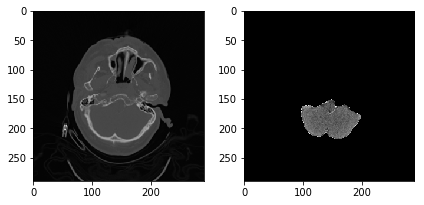

In [420]:
from skimage.transform import hough_ellipse
from skimage.feature import canny
from skimage.draw import ellipse_perimeter
import cv2

def segment(image):
    # Create binary image
    binary_image = np.array(image)
    binary_image = (binary_image > 200)
#     return binary_image

    # Split image by region, then strip outer layer
    tmp = binary_image
    tmp = dilation(tmp)
#     tmp = closing(tmp, disk(5))
#     return tmp
    tmp = measure.label(tmp)
    area = [r.area for r in measure.regionprops(tmp)]
    tmp[tmp != np.argmax(area) + 1] = -1
    tmp[tmp == np.argmax(area) + 1] = 0
#     return tmp
    tmp = np.pad(tmp, [(20, 20), (20, 20)], mode='constant', constant_values=-1)
#     tmp = dilation(tmp)
    tmp = closing(tmp, disk(5))
    if len(np.unique(clear_border(tmp, bgval=0))) == 1:
        img_res = np.uint8(tmp) + 1
        edges = cv2.Canny(np.uint8(tmp), 50, 200)
        _, contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        contours = list(contours)
        contours.sort(key=lambda x : len(x))
        ellipse = cv2.fitEllipse(contours[-1])
        img_res = cv2.ellipse(img_res, ellipse, 1, thickness=2)
        tmp = np.int64(img_res) - 1
#     return tmp
    tmp_border = clear_border(tmp, bgval=0)
#     return tmp_border
    tmp_border[tmp_border == -1] = 1
#     return tmp_border[20:-20, 20:-20]

    # Split image by region, then again strip outer layer
    tmp_border = measure.label(tmp_border)
    area = [r.area for r in measure.regionprops(tmp_border)]
    tmp_border[tmp_border != np.argmax(area) + 1] = 0
    tmp_border[tmp_border == np.argmax(area) + 1] = 1
#     return tmp_border[20:-20, 20:-20]
    tmp_border = dilation(tmp_border, disk(1))
    tmp_border = closing(tmp_border)
    tmp_border = remove_small_holes(tmp_border)
#     tmp_border = convex_hull_image(tmp_border)
#     return tmp_border[20:-20, 20:-20]
    mask_index = (tmp_border[20:-20,20:-20] == 0)
    result = np.array(image)
    result[mask_index] = -50
    return result

example_image = processed_dict_1['P4AIB8JMDY6RDRAP'][11,:,:]
segmented = segment(example_image)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.imshow(example_image, cmap='gray')
ax = fig.add_subplot(1, 2, 2)
plt.imshow(segmented, cmap='gray')
fig.tight_layout()
plt.plot()

In [340]:
processed_df = labels_df.loc[processed_dict.keys()]

## Data Validation

Check to see that the data looks right.

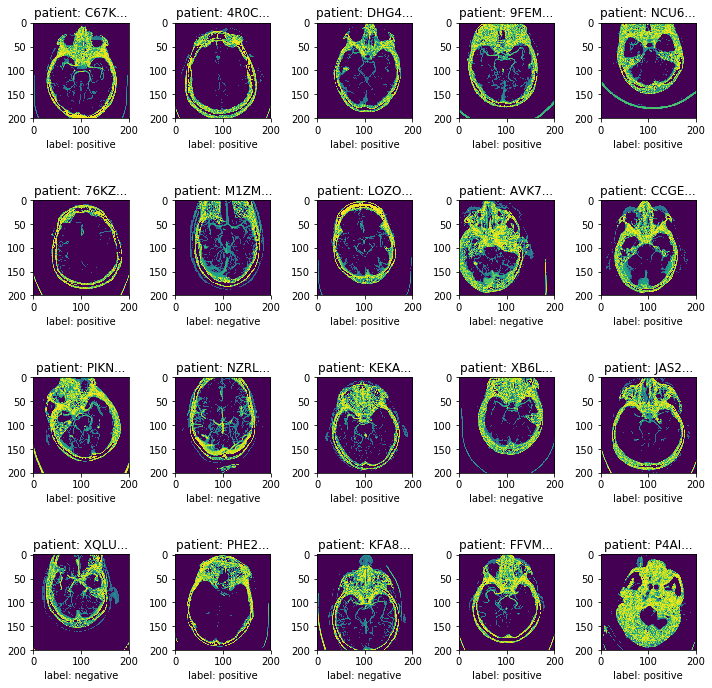

In [412]:
plot_images({k: arr[:,:,0] for k, arr in processed_dict.items()}, labels_df, 5, offset=120)

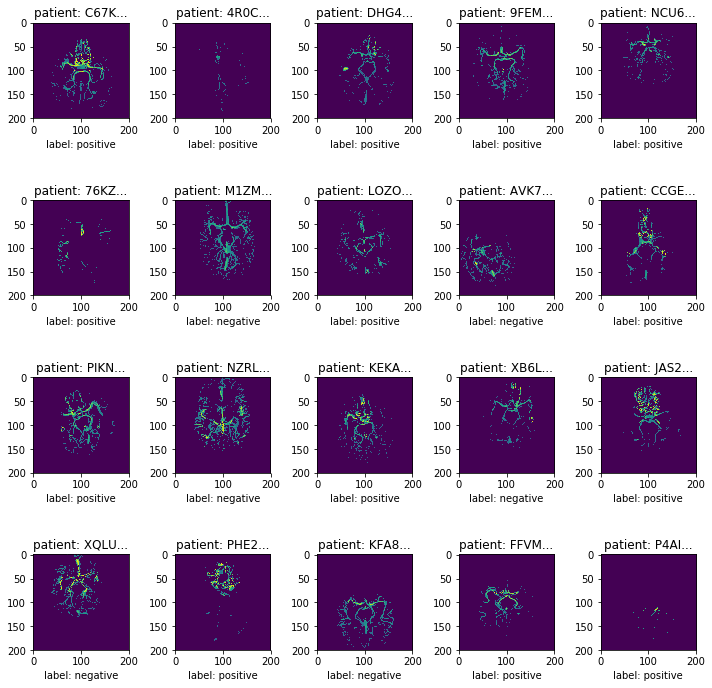

In [424]:
plot_images({k: arr[:,:,0] for k, arr in processed_dict_3.items()}, labels_df, 5, offset=120)

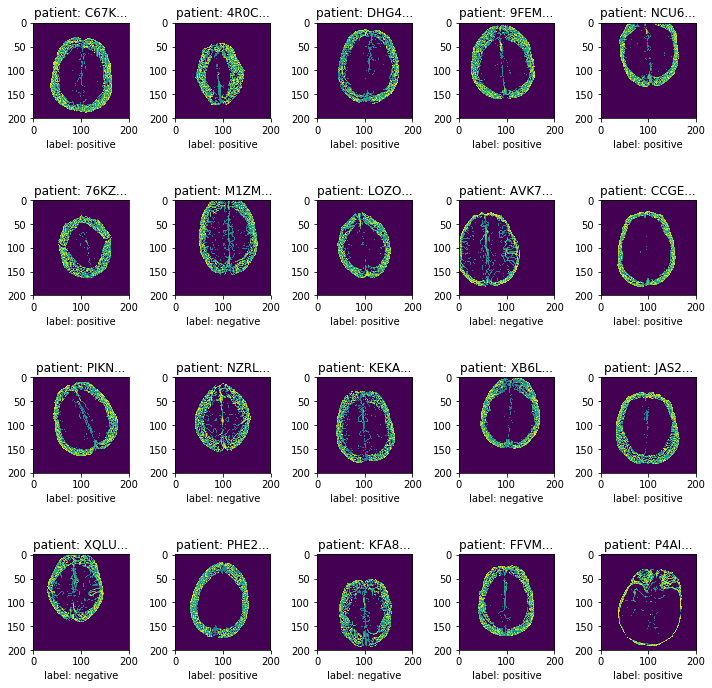

In [375]:
plot_images({k: arr[:,:,2] for k, arr in processed_dict_3.items()}, labels_df, 5, offset=120)

## Saving the Data

Once you've preprocessed data to your liking, you should save the data to 
disk. Load the data from disk in your model building notebook.

In [351]:
# Changed the preprocessed path
processed_dirpath = '/home/elvo-analysis/data/vessel_3'
os.mkdir(processed_dirpath)
arr: np.ndarray
for id_, arr in processed_dict_3.items():
    np.save(pathlib.Path(processed_dirpath) / f'{id_}.npy', arr)

In [347]:
processed_df.to_csv('/home/elvo-analysis/data/labels_nb.csv')

1061


## Sharing the Data
If the data works well in models, you should share it with others.
Make sure to update the [Code and Data Doc](https://docs.google.com/document/d/1_vaNcfZ_E5KsOZH_rNf4w_wTIr7EvI8GqpZ5o3dAUV4/edit)
if you do upload to GCS.

In [ ]:
# !gsutil rsync -d -r PATH/TO/PROCESSED/DATA gs://PATH/TO/SAVE/TO

In [ ]:
 #!gsutil rsync -d PATH/TO/PROCESSED/LABELS gs://PATH/TO/SAVE/TO